#Download data from Wikipedia

In [0]:
!wget https://wikimedia.mirror.us.dev/fawiki/20200301/fawiki-20200301-pages-articles-multistream.xml.bz2

--2020-03-28 15:32:52--  https://wikimedia.mirror.us.dev/fawiki/20200301/fawiki-20200301-pages-articles-multistream.xml.bz2
Resolving wikimedia.mirror.us.dev (wikimedia.mirror.us.dev)... 96.90.175.164, 2603:300b:901:bb00:feed::1
Connecting to wikimedia.mirror.us.dev (wikimedia.mirror.us.dev)|96.90.175.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 807361413 (770M) [application/octet-stream]
Saving to: ‘fawiki-20200301-pages-articles-multistream.xml.bz2’

fawiki-20200301-pag 100%[===================>] 769.96M  2.85MB/s    in 4m 44s  

2020-03-28 15:37:38 (2.71 MB/s) - ‘fawiki-20200301-pages-articles-multistream.xml.bz2’ saved [807361413/807361413]



In [0]:
!bzip2 -d "fawiki-20200301-pages-articles-multistream.xml.bz2"


In [0]:
!ls

fawiki-20200301-pages-articles-multistream.csv	sample_data
fawiki-20200301-pages-articles-multistream.xml


In [0]:
!git clone https://github.com/attardi/wikiextractor.git

Cloning into 'wikiextractor'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 613 (delta 2), reused 2 (delta 0), pack-reused 607
Receiving objects: 100% (613/613), 1.26 MiB | 1.42 MiB/s, done.
Resolving deltas: 100% (350/350), done.


In [0]:
!python3 wikiextractor/WikiExtractor.py -s --json --no_templates -q fawiki-20200301-pages-articles-multistream.xml

In [0]:
datasetpath =  Path('/content/')

LANG_FILENAMES = [str(f) for f in datasetpath.rglob("text/*/*")]


In [0]:
len(LANG_FILENAMES), LANG_FILENAMES[:5]


(867,
 ['/content/text/AG/wiki_81',
  '/content/text/AG/wiki_89',
  '/content/text/AG/wiki_49',
  '/content/text/AG/wiki_46',
  '/content/text/AG/wiki_19'])

In [0]:
ls /content

fawiki-20200301-pages-articles-multistream.xml  text/
sample_data/                                    wikiextractor/


In [0]:
LANG_TEXT = []
for fn in LANG_FILENAMES:
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [0]:
LANG_TEXT.head()

,id,url,title,text,length
0,3835814,https://fa.wikipedia.org/wiki?curid=3835814,دستینی (دی‌سی کامیکس),دستینی (دی‌سی کامیکس)\n\nدِستینی یک شخصیت خیال...,1033
1,3835815,https://fa.wikipedia.org/wiki?curid=3835815,مایکل استون‌براکر,مایکل استون‌براکر\n\nمیکائیل استون‌براکر یک دا...,883
2,3835822,https://fa.wikipedia.org/wiki?curid=3835822,میرزا عبدالقادر پاوه‌ای,میرزا عبدالقادر پاوه‌ای\n\nمیرزا عبدالقادر پاو...,577
3,3835984,https://fa.wikipedia.org/wiki?curid=3835984,پتر هوگل,پتر هوگل\n\nپتر هوگل (زادهٔ ۱۹ اوت ۱۸۹۷- مرگ ۲...,699
4,3835985,https://fa.wikipedia.org/wiki?curid=3835985,ریل باس,ریل باس\n\nریل باس نوعی قطار مسافری خودکشش می‌...,603


In [0]:
LANG_TEXT.to_pickle("wikipedia_persian.pckl")

#model building time

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp '/content/gdrive/My Drive/InsightfactoryPlayground/wikipedia_persian.pckl' wikipedia_persian.pckl


In [0]:
!cp  '/content/gdrive/My Drive/InsightfactoryPlayground/wikipedia_data_lm.pkl' data_lm.pkl

In [0]:
from fastai.text import *
import html
from matplotlib import pyplot
import numpy
import time
import pandas as pd

#Creating TextList


In [0]:
LANG_TEXT = pd.read_pickle("wikipedia_persian.pckl")

In [0]:
!ls -lrt --block-size=M

total 834M
drwxr-xr-x 1 root root   1M Mar 18 16:23 sample_data
drwx------ 4 root root   1M Mar 29 09:51 gdrive
-rw------- 1 root root 834M Mar 29 09:53 wikipedia_persian.pckl


In [0]:
LANG_TEXT.shape

(712163, 4)

In [0]:
def split_title_from_text(text):
    words = text.split("\n\n", 1)
    if len(words) == 2:
        return words[1]
    else:
        return words[0]
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [0]:
LANG_TEXT['length'] = LANG_TEXT['text'].str.len()


In [0]:

percentages = range(0,110,10)
print ('Article length percentiles' , ', '.join(['{}%: {}'.format(p, int(q))  for p,q in zip(percentages, numpy.percentile(LANG_TEXT['length'], percentages))]))
print ('Number of articles', len(LANG_TEXT))

Article length percentiles 0%: 0, 10%: 62, 20%: 94, 30%: 121, 40%: 154, 50%: 191, 60%: 221, 70%: 267, 80%: 488, 90%: 1190, 100%: 109795
Number of articles 712163


In [0]:
LANG_TEXT = LANG_TEXT[LANG_TEXT.length> 200]

In [0]:
LANG_TEXT.to_csv("wikipedia_persian.csv")

In [0]:
del LANG_TEXT
import gc
gc.collect()

220

In [0]:
data_lm = TextList.from_csv(".", "wikipedia_persian.csv",cols="text").split_by_rand_pct(0.1).label_for_lm().databunch(bs=32)

In [0]:
data_lm.save('data_lm.pkl')


In [0]:
!cp data_lm.pkl '/content/gdrive/My Drive/InsightfactoryPlayground/wikipedia_data_lm.pkl' 


In [0]:
!pip freeze | grep torch

torch==1.4.0
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.5.0


#Train time

In [0]:
batch_size = 128

In [0]:
data_lm = load_data(".", "data_lm.pkl",bs=batch_size)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


In [0]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


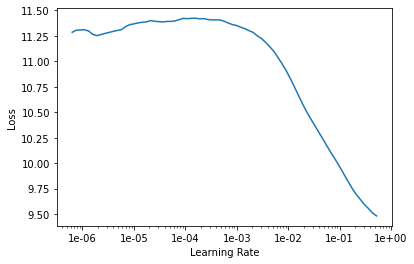

In [0]:
learn.recorder.plot(skip_end=15)


In [0]:
learn.fit_one_cycle(1, max_lr=slice(1e-3,1e-1), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.885179,4.679333,0.273516,1:03:46


In [0]:
learn.save("stage-1")

In [0]:
!cp models/stage-1.pth '/content/gdrive/My Drive/InsightfactoryPlayground/persian-wikipedia-stage-1.pth' 

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


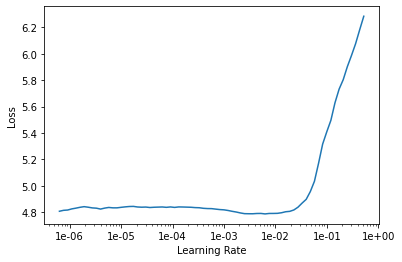

In [0]:
learn.recorder.plot(skip_end=15)


In [0]:
learn.fit_one_cycle(1, max_lr=slice(51e-3,1e-2), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.020819,3.929113,0.336036,1:04:06


In [0]:
learn.save('fit_head')


In [0]:
learn.save_encoder('fine_tuned_enc')


In [0]:
!cp models/fit_head.pth '/content/gdrive/My Drive/InsightfactoryPlayground/persian-wikipedia-stage-1.pth' 

In [0]:
!cp models/fine_tuned_enc.pth '/content/gdrive/My Drive/InsightfactoryPlayground/fine_tuned_enc.pth' 

In [0]:
learn.fit_one_cycle(1, max_lr=slice(51e-3,1e-2), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.032256,3.910661,0.337358,1:04:10


In [0]:
learn.save('fit_head')
learn.save_encoder('fine_tuned_enc')


In [0]:
!cp models/fit_head.pth '/content/gdrive/My Drive/InsightfactoryPlayground/persian-wikipedia-stage-1.pth' 
!cp models/fine_tuned_enc.pth '/content/gdrive/My Drive/InsightfactoryPlayground/fine_tuned_enc.pth' 